In [2]:
#-- Import general libraries
import os
import numpy as np
import pandas as pd
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import sys
import scipy
from IPython.display import display, clear_output

In [3]:
# Specify size of the domain
Nx = 101
xa = 0
xb = 1

# Time setup
hour = 3600
dt = hour;
Nt = 100;
t_total = Nt*dt;
time = np.linspace(0, t_total,Nt+1);

daterange = time/hour

# Create a meshgrid
x = np.linspace(xa, xb, Nx) # np array
dx = (xb-xa)/(Nx-1)
depth_measurement = 0.05
depth_i = int(np.floor(depth_measurement/dx))

#Thermal & radiation properties
Ta = 296
epsilon = 0.95
sigma = 5.67e-8
K_down = 800
L_down = 100


#Min & Max values of parameters
alpha0 = 0.05
alpha1 = 0.5
h0 = 5
h1 = 20 
beta0 = 0.5
beta1 = 5 
C0 = 2e6 
C1 = 2.5e6 
Tb0 = 290 
Tb1 = 303
Lambda0 = 0.47
Lambda1 = 0.8 

#True values
alpha_true = 0.2
Lambda_true = 0.8
Tb_true = 293
C_true = 2.2e6
beta_true = 1.5
h_true = 15

In [4]:
trise = 7*hour
tset = 21*hour

t24 = np.mod(time, 24*hour);
theta=(t24-trise)/(tset-trise)*np.pi/2 + (t24-tset)/(tset-trise)*np.pi/2;
for i in range(Nt+1):
    if abs(theta[i]) > np.pi/2:
        theta[i] = theta[i]/abs(theta[i])*np.pi/2

K_down_array = K_down*np.cos(theta)
L_down_array = L_down*np.ones(Nt+1)
Ta_array = Ta*np.ones(Nt+1)

In [5]:
class HeatEqConv(nn.Module):
    def __init__(self, Nx, filter_weight): #filter_weight
        super(HeatEqConv, self).__init__()

        # Specify the size of the input (batch_size, channels, width)
        input_size = (1, 1, Nx)  # Adjust the size based on your requirements
        batch_size, in_channels, width = input_size

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]

        # Create a Conv1d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv1d(in_channels, out_channels=1,kernel_size=kernel_size, padding='valid', bias=False)
        self.conv_layer.weight.data = filter_weight

    def forward(self, previous):

        future = self.conv_layer(previous) # previous(1,1,Nx); future(1,1,Nx-2)
        return future

In [6]:
# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(np.array(x), dtype=torch.float64)

# filter corresponding to the second order central difference of the second derivative
filter = torch.tensor([1, 0., 1], dtype=torch.float64)

# resize filter for PyTorch
# filter_weight(num_kernels/output channels, kernel_height, kernel_width)
filter_weight = filter.view(1, 1, filter.shape[0])

# Create instance of convolution and use it as a function to apply convolution
mymodel_time_march = HeatEqConv(Nx,filter_weight)

In [9]:
class HeatEqBackProp_DirichletBC(nn.Module):
    def __init__(self,alpha,h,beta,C,Tb,Lambda):
        super(HeatEqBackProp_DirichletBC, self).__init__()
        Tb.retain_grad()
        h.retain_grad()
        alpha.retain_grad()
        beta.retain_grad()
        C.retain_grad()
        Lambda.retain_grad()

    def forward(self,mymodel_time_march,Nt,start):

        Ts_array = torch.zeros(Nt+1,dtype=torch.float64)
        T5_array = torch.zeros(Nt+1,dtype=torch.float64)
        Ts_array[0] = Tb
        T5_array[0] = Tb
        Tn1 = Tb*torch.ones(Nx,dtype=torch.float64)
        Tn1_midday_norm = torch.zeros([math.floor((Nt+start)/24),Nx])
        tol = 1e-4

        #Solve for temperature at measurement depth
        for t in range(start,Nt+start):
            Tn1 = HeatEqSolver_DirichletBC(mymodel_time_march,Tn1,tol,K_down_array[t+1],L_down_array[t+1],Ta_array[t+1],alpha,h,beta,C,Tb,Lambda)
            Ts_array[t-start+1] = Tn1[0]
            T5_array[t-start+1] = Tn1[depth_i]

        return Ts_array,T5_array,Tn1

In [10]:
def HeatEqSolver_DirichletBC(mymodel_time_march,Tn, tol,K_down,L_down,Ta,alpha,h,beta,C,Tb,Lambda):
    error = 9e9
    # first guess
    Tn1_k = Tn
    # recalculate r
    r = Lambda/C*dt/(dx**2)
    while(error>tol):
        # Input kth approximation of Tn+1 into NN -> transform into 3D tensor
        Tn1_k_tensor= Tn1_k.view(1, 1, Nx)
        # Apply convolution to obtain (k+1)th approximation of Tn+1 for interior nodes
        Tn1_k1_tensor = 1/(1+2*r)*(r*mymodel_time_march(Tn1_k_tensor) + Tn[1:-1])
        # Calculate new Tn+1 at boundary based on Tn and kth approximation of Tn+1
        Tn1_k1_0 = 1/(1+2*r*(1+dx/Lambda*(h*(1+1/beta)+sigma*epsilon*Tn1_k[0]**3)))*(Tn[0]+2*r*(Tn1_k[1]+dx/Lambda*(K_down*(1-alpha) + L_down + h*(1+1/beta)*Ta)))
        # Append BCs
        #Tn1_k1_tensor  = torch.cat((Tn1_k1_0, Tn1_k1_tensor[0,0,:], Tn1_k1_tensor[0,0,-1:]),0)
        Tn1_k1_tensor  = torch.cat((Tn1_k1_0, Tn1_k1_tensor[0,0,:], Tb),0)
        # Calculate relative error
        error = torch.max(torch.abs(Tn1_k1_tensor-Tn1_k))
        # Continue from (k+1)th approximation
        Tn1_k = Tn1_k1_tensor


    return Tn1_k1_tensor

In [13]:
start = 0 #time at which optimisation starts

alpha = torch.tensor([alpha_true], dtype=torch.float64,requires_grad=True)
h = torch.tensor([h_true], dtype=torch.float64,requires_grad=True)
beta = torch.tensor([beta_true], dtype=torch.float64,requires_grad=True)
C = torch.tensor([C_true], dtype=torch.float64,requires_grad=True)
Lambda = torch.tensor([Lambda_true], dtype=torch.float64,requires_grad=True)
Tb = torch.tensor([Tb_true], dtype=torch.float64,requires_grad=True)

# Define a single model
model = HeatEqBackProp_DirichletBC(alpha,h,beta,C,Tb,Lambda)

# Forward pass through the model
[Ts_array_output_1hr_DirichletBC,T5_array_output_1hr_DirichletBC,Tn1_output] = model(mymodel_time_march,Nt,start)

In [17]:
start = 0 #time at which optimisation starts

hour = 3600
dt = 60;
Nt = 100*60;
t_total = Nt*dt;
time = np.linspace(0, t_total,Nt+1);

trise = 7*hour
tset = 21*hour

t24 = np.mod(time, 24*hour);
theta=(t24-trise)/(tset-trise)*np.pi/2 + (t24-tset)/(tset-trise)*np.pi/2;
for i in range(Nt+1):
    if abs(theta[i]) > np.pi/2:
        theta[i] = theta[i]/abs(theta[i])*np.pi/2

K_down_array = K_down*np.cos(theta)
L_down_array = L_down*np.ones(Nt+1)
Ta_array = Ta*np.ones(Nt+1)

daterange = time/hour

alpha = torch.tensor([alpha_true], dtype=torch.float64,requires_grad=True)
h = torch.tensor([h_true], dtype=torch.float64,requires_grad=True)
beta = torch.tensor([beta_true], dtype=torch.float64,requires_grad=True)
C = torch.tensor([C_true], dtype=torch.float64,requires_grad=True)
Lambda = torch.tensor([Lambda_true], dtype=torch.float64,requires_grad=True)
Tb = torch.tensor([Tb_true], dtype=torch.float64,requires_grad=True)

time = np.linspace(0, t_total,Nt+1);
daterange = time/hour

# Define a single model
model = HeatEqBackProp_DirichletBC(alpha,h,beta,C,Tb,Lambda)

# Forward pass through the model
[Ts_array_output_60s_DirichletBC,T5_array_output_60s_DirichletBC,Tn1_output] = model(mymodel_time_march,Nt,start)

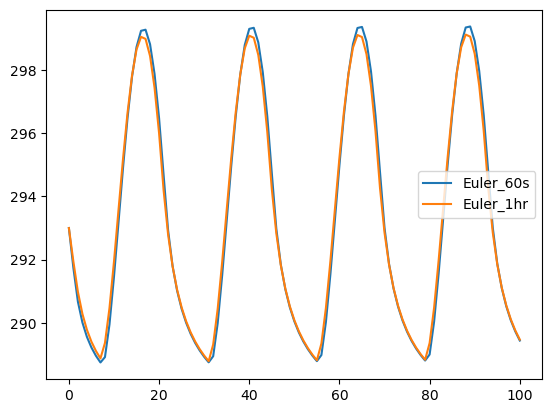

In [18]:
plt.plot(daterange[0::60],T5_array_output_60s_DirichletBC[0::60].detach().numpy(),label='Euler_60s')
plt.plot(daterange[0::60],T5_array_output_1hr_DirichletBC.detach().numpy(),label='Euler_1hr')
plt.legend()

In [19]:
with open('Target_Ts_euler.txt','w') as outfile:
    np.savetxt(outfile,Ts_array_output_1hr_DirichletBC.detach().numpy(),fmt='%-7.6e')

with open('Target_T5_euler.txt','w') as outfile:
    np.savetxt(outfile,T5_array_output_1hr_DirichletBC.detach().numpy(),fmt='%-7.6e')